<a href="https://colab.research.google.com/github/Jun-Liu-291/10-Animals/blob/master/Animals_10_v5_Pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/dataset/tenAnimals_no_shuffle

!pwd

/content/drive/My Drive/dataset/tenAnimals_no_shuffle
/content/drive/My Drive/dataset/tenAnimals_no_shuffle


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

Using TensorFlow backend.


In [ ]:
import os

BASE_PATH = '/content/drive/My Drive/dataset/tenAnimals_no_shuffle'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'validation')
TEST_PATH = os.path.join(BASE_PATH, 'test')

batch_size = 128
epochs = 80
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale = 1./ 255,
    rotation_range = 30,
    width_shift_range = .15,
    height_shift_range = .15,
    horizontal_flip = True,
    zoom_range = 0.3
)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = TRAIN_PATH,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
)

validation_data_gen = validation_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = VAL_PATH,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
)

Found 10241 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


In [ ]:
# model architcture
from keras import optimizers

model = Sequential([Conv2D(32, 3, padding = 'same', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)), LeakyReLU(),
                    Conv2D(32, 3, padding = 'same'), LeakyReLU(),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding = 'same'), LeakyReLU(),
                    Conv2D(64, 3, padding = 'same'), LeakyReLU(),
                    MaxPooling2D(),
                    Conv2D(128, 3, padding = 'same'), LeakyReLU(),
                    Conv2D(128, 3, padding = 'same'), LeakyReLU(),
                    MaxPooling2D(),
                    Conv2D(256, 3, padding = 'same'), LeakyReLU(),
                    Conv2D(256, 3, padding = 'same'), LeakyReLU(),
                    MaxPooling2D(),
                    Conv2D(512, 3, padding = 'same'), LeakyReLU(),
                    Conv2D(512, 3, padding = 'same'), LeakyReLU(),
                    MaxPooling2D(),
                    Conv2D(1024, 3, padding = 'same'), LeakyReLU(),
                    Conv2D(1024, 3, padding = 'same'), LeakyReLU(),
                    Flatten(),
                    Dropout(0.4),
                    Dense(1024), LeakyReLU(),
                    Dense(1024), LeakyReLU(),
                    Dense(10, activation='softmax')])

# setting the optimizer and learning rate
learning_rate = 1e-4
optimizer = optimizers.Adam(learning_rate = 1e-4)
  
# Compile the model with the optimizer and learning rate specified in hpyarams
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
# change callback function
# apply ReduceLRonPlateau for changing LR
reduceLR = ReduceLROnPlateau(
    monitor="loss",
    factor = 0.5,
    patience = 5,
    verbose = 1,
    mode = 'min',
    min_lr = 1e-6)

# save whole model when get a better val accuracy
checkpoint = ModelCheckpoint(
    filepath = '10A_ns.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_acc',
    save_weights_only = False,
    save_best_only = True
)

my_callbacks = [reduceLR, checkpoint]

# set learning rate by different epochs
lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64, 64, 64)       

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(10240/batch_size),
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=int(1028/batch_size),
    #callbacks = [lr_schedule]
    callbacks = my_callbacks
)

Epoch 1/80
80/80 [==============================] - 92s 1s/step - loss: 2.2680 - acc: 0.1379 - val_loss: 2.2777 - val_acc: 0.1895
Epoch 2/80
80/80 [==============================] - 92s 1s/step - loss: 2.0301 - acc: 0.2579 - val_loss: 2.0888 - val_acc: 0.2842
Epoch 3/80
80/80 [==============================] - 91s 1s/step - loss: 1.9581 - acc: 0.2782 - val_loss: 1.8040 - val_acc: 0.3555
Epoch 4/80
80/80 [==============================] - 90s 1s/step - loss: 1.7924 - acc: 0.3435 - val_loss: 1.8012 - val_acc: 0.3701
Epoch 5/80
80/80 [==============================] - 90s 1s/step - loss: 1.7543 - acc: 0.3627 - val_loss: 2.0800 - val_acc: 0.3369
Epoch 6/80
80/80 [==============================] - 90s 1s/step - loss: 1.6743 - acc: 0.3937 - val_loss: 2.1566 - val_acc: 0.2988
Epoch 7/80
80/80 [==============================] - 90s 1s/step - loss: 1.8119 - acc: 0.3530 - val_loss: 1.9323 - val_acc: 0.3203
Epoch 8/80
80/80 [==============================] - 89s 1s/step - loss: 1.6178 - acc: 0.41

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-2, 1, 2.9])

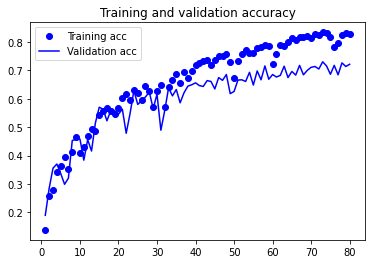

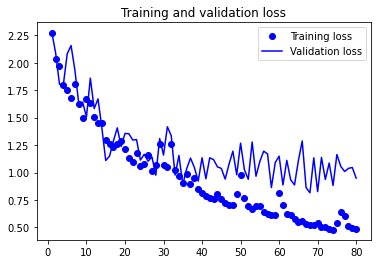

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save('10_Animals_ns.h5')